In [1]:
from __future__ import division
import cPickle as pkl
import matplotlib.pyplot as plt
from multiprocessing import Pool
import numpy as np
import os
import pandas as pd
from tqdm import tqdm
%matplotlib inline

# Quick inspection

In [2]:
cc = pkl.load(open('../tmp/dump_2009_class_1__raw_data_.pkl','rb'))
rd, ei = cc['raw_data'], cc['extra_info']

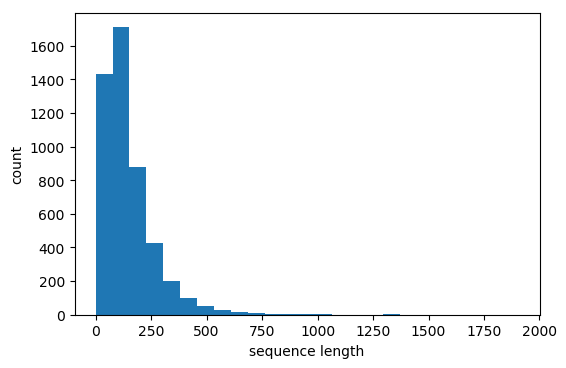

In [3]:
lenghts = [len(rd[k]) for k in rd.keys()]

plt.figure(dpi=100)
plt.hist(lenghts, bins=25)
plt.xlabel('sequence length')
plt.ylabel('count');

In [4]:
for i, k in enumerate(rd.keys()):
    print('* {}'.format(rd[k]))
    if i>3: break

* T0G0T0G1T0G2G0T2G0T2T0G0T0G2T0G2T0G1P0T0P0G0P0P0P0P0T0B0T0P0P0P0I0P0G0T0B0T0P0P0T0G0I0I0I0I0B0T0T0G1P0P0B0P0P0I1G0T0T0G0B0T0G0P0P0G0T0B0E0E0P0P
* O0O2G3P0P0P0P0G2P0P0G0P0G0T0G3G0G0E1E0S0S0S0G2G0E0E0S0P0P0S0I0G1P0P
* G0T0P0P0P0P0G0T1O0T0G0E0T0T0G0G0T0T0G1L0G0T0S0E0S0G0T0T0G1O0T0G3T0P0P0G0P0L0O0T0G0T0T1T0G0P0P0T0P0I0E0E0G0T0O0I0E0S0G0T0G0T0P0P0P0P0E0G0T0G0T0T0G0L0L0L0L0L0L0E0L0L0L0T0G0T0G0G0G0T0T1G0T0O0L0G0T0G0T0E0P0P0P0P0G0T0E0G0T0O0T0G0T0G0T0G0G0T0T0G0G0T0D0T0G0T0E0P0P0P0P0T0G0O0G0G0T0T0T0G0L0T0L0G0L0L0G0T0O0E0E0P0P0P0P0P0T0G0P0P0T0G1G0T0G0T0G0T0G0T0O0G0T0O
* T0G0P0P0T0E0P0P0G0T0I2G0T2T0G0P0P0P0P0P0P0E0P0P0P0T0G0P0P0T0P0P0E0E0S0S0E0E0E1T0G0G0T0E1E0E0P0P0P0P0E2E0T0G0G0T0P0P0P0P0P0P0P0P1E0I0I0G0T0I0T0G1T0G1E0I0T0G0P0T0G0P
* G0T0G0T0E0G0T0G0T0G0T0T0G2G0T1T0G0G0T0P0T0G0P0P0P0P0P0G0T0T0G2G0T1T0G0T0G0T0G0T0G0T0G0T0G0G0T0E0S0T0G1T0G2G0T2T0G0T0G0P0P0T0G0G0T0T0G2T0G0T0G2G0T0P0P0P0P0G0P0P0P0T1G0T2G0T1T0G0G0T1T0G


# Load raw data

In [6]:
def load_data(dump_files):
    """Extract sequences, extra info and patient id from dump pkl."""
    # Positive raw data load
    raw_data = []
    extra_info = []
    indexes = []
    for f in tqdm(dump_files, desc='Loading dump files'):
        _tmp = pkl.load(open(os.path.join('..', 'tmp', f), 'rb'))
        _raw_data, _extra_info = _tmp['raw_data'], _tmp['extra_info'].set_index('PIN')
        for k in _extra_info.index:
            if len(_raw_data[k])>0: # Skip empty sequences
                raw_data.append(_raw_data[k])
                extra_info.append([_extra_info.loc[k]['SEX'], _extra_info.loc[k]['AGE']])
                indexes.append(k)
#             else:
#                 print('empty {}'.format(k))
    return raw_data, extra_info, indexes

In [7]:
dump_files = filter(lambda x: 'raw_data' in x, os.listdir('../tmp/'))
positive_dump_files = filter(lambda x: 'class_1' in x, dump_files)
negative_dump_files = filter(lambda x: 'class_0' in x, dump_files)

Sequences should be like `['A', 8, 'M', 0, ...]` where letters are btos and numbers are weeks from one btos to another

In [8]:
pos_raw_data, pos_extra_info, pos_id = load_data(positive_dump_files)
print(len(pos_id), 'positive samples')

Loading dump files: 100%|██████████| 6/6 [00:09<00:00,  1.63s/it]

(28811, 'positive samples')


In [9]:
neg_raw_data, neg_extra_info, neg_id = load_data(negative_dump_files)
print(len(neg_id), 'negative samples')

Loading dump files: 100%|██████████| 1/1 [01:50<00:00, 110.57s/it]

(328841, 'negative samples')


# EDA
I want to use the negative samples with comparable length.

5%:61.0 | 95%965.0


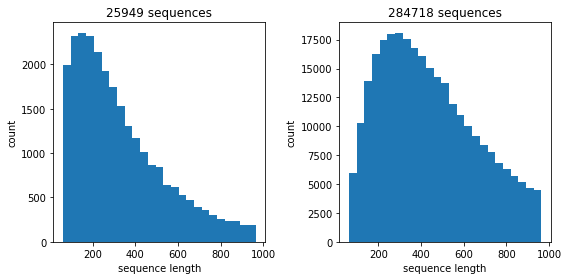

In [20]:
# Extracting the lenghts of the positive
lenghts = np.array([len(x) for x in pos_raw_data])

# Calculating 5-95 percentile
p5 = np.percentile(lenghts, 5)
p95 = np.percentile(lenghts, 95)
print('5%:{} | 95%{}'.format(p5, p95))

# Identifying the indexes
pos_idx595 = np.argwhere(np.logical_and(lenghts>=p5, lenghts<=p95)).ravel()
pos_lenghts = lenghts[pos_idx595]

# And for negative class as well
lenghts = np.array([len(x) for x in neg_raw_data])
neg_idx595 = np.argwhere(np.logical_and(lenghts>=p5, lenghts<=p95)).ravel()
neg_lenghts = lenghts[neg_idx595]


plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.hist(pos_lenghts, bins=25)
plt.title('{} sequences'.format(len(pos_lenghts)))
plt.xlabel('sequence length')
plt.ylabel('count')

plt.subplot(122)
plt.hist(neg_lenghts, bins=25)
plt.title('{} sequences'.format(len(neg_lenghts)))
plt.xlabel('sequence length')
plt.ylabel('count')

plt.tight_layout();

In [25]:
# Extract only the relevant samples
pos_raw_data595 = [pos_raw_data[i] for i in pos_idx595]
neg_raw_data595 = [neg_raw_data[i] for i in neg_idx595]

In [28]:
pos_extra_info595 = [pos_extra_info[i] for i in pos_idx595]
neg_extra_info595 = [neg_extra_info[i] for i in neg_idx595]

# Make Xy

In [66]:
# Bag-of-words representation
from sklearn.feature_extraction.text import CountVectorizer

bow = CountVectorizer(analyzer='char')#, ngram_range=[1, 3])
X1 = bow.fit_transform(pos_raw_data595).todense()
print(X1.shape)

X0 = bow.transform(neg_raw_data595).todense()
print(X0.shape)

(25949, 17)
(284718, 17)


In [67]:
# Vocabulary inspection
# print(bow.vocabulary_.keys())

In [68]:
# Adding extra info
def add_extra_info(X, extra_info):
    extra_info = np.array(extra_info)
    extra_info[:, 0] = np.where(extra_info[:,0] == 'F', 1, 0) # mapping F->1 | M->0
    extra_info = extra_info.astype(np.int)
    return np.hstack((X, extra_info))

X1 = add_extra_info(X1, pos_extra_info595)
print(X1.shape)

X0 = add_extra_info(X0, neg_extra_info595)
print(X0.shape)

(25949, 19)
(284718, 19)


In [69]:
# Feature names
feat_names = bow.vocabulary_.keys()
feat_names.append('SEX')
feat_names.append('AGE')
print(feat_names)

[u's', u'r', u'b', u'e', u'd', u'g', u'0', u'i', u'h', u'l', u'o', u'1', u'p', u'3', u'2', u't', u'4', 'SEX', 'AGE']


In [70]:
np.save('X0_n1.npy', X0)
np.save('X1_n1.npy', X1)
np.save('feat_names_n1.npy', np.array(feat_names))

In [71]:
# Create a balanced training set
n = X1.shape[0]

# Subsample X1
idx = np.arange(n)
np.random.shuffle(idx)
X1_small = X1[idx, :]

# Subsample X0
idx = np.arange(n)
np.random.shuffle(idx)
X0_small = X0[idx, :]

# Stack them
X_small = np.vstack((X1_small, X0_small))
y_small = np.hstack((np.ones(X1_small.shape[0]), np.zeros(X0_small.shape[0])))
print(X_small.shape)
print(y_small.shape)

(51898, 19)
(51898,)


In [72]:
# Simple assessment
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

scores = cross_validate(LogisticRegression(), X_small, y_small, cv=5, n_jobs=-1)
print('Training: avg score: {:2.3f} +- {:2.3f}'.format(np.mean(scores['train_score']), np.std(scores['train_score'])))
print('Validation: avg score: {:2.3f} +- {:2.3f}'.format(np.mean(scores['test_score']), np.std(scores['test_score'])))

Training: avg score: 0.899 +- 0.000
Validation: avg score: 0.899 +- 0.003


In [73]:
from sklearn.ensemble import RandomForestClassifier

scores = cross_validate(RandomForestClassifier(n_estimators=500, n_jobs=-1), X_small, y_small, cv=5)
print('Training: avg score: {:2.3f} +- {:2.3f}'.format(np.mean(scores['train_score']), np.std(scores['train_score'])))
print('Validation: avg score: {:2.3f} +- {:2.3f}'.format(np.mean(scores['test_score']), np.std(scores['test_score'])))

Training: avg score: 1.000 +- 0.000
Validation: avg score: 0.904 +- 0.003


In [74]:
# Build a forest and compute the feature importances
forest = RandomForestClassifier(n_estimators=500, n_jobs=-1)

forest.fit(X_small, y_small)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

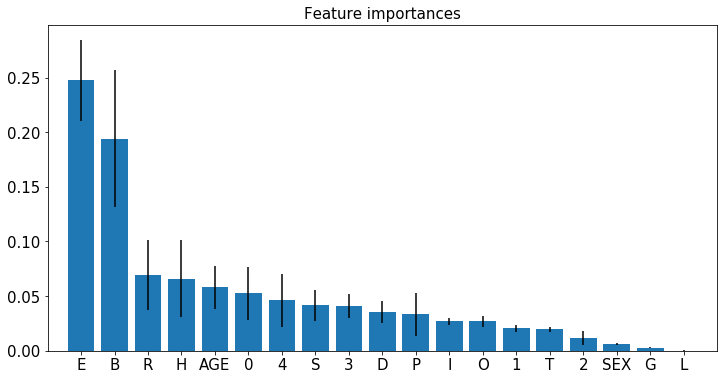

In [86]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
# print("Feature ranking:")

# for f in range(X_small.shape[1]):
#     print("%d. feature %s (%f)" % (f + 1, feat_names[f], importances[indices[f]]))

# Plot the feature importances of the forest
top_k = 19
plt.figure(figsize=(12, 6))
plt.title("Feature importances", fontsize=15)
plt.bar(range(top_k), importances[indices][:top_k], yerr=std[indices[:top_k]], align="center")
plt.xticks(range(top_k), [s.upper() for s in np.array(feat_names)[indices][:top_k]], fontsize=15)
plt.yticks(fontsize=15)
plt.xlim([-1, top_k]);